In [1]:
# select the guide stars given a field

import warnings
warnings.filterwarnings("ignore")

import ceo
import yaml
from yaml import Loader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.expanduser('~/PYTHON/ATP/'))
from astropy.units import Quantity
from astropy.time import Time
import astropy.io.fits as pyfits
import atp
import copy
from agwsprobes import *
import scipy.interpolate

/home/ubuntu/CEO/python/ceo/zemax


In [2]:
config = "fp"
if config == 'fp':
    agws_config = 'm3'
else:
    agws_config = config
maxstarsperprobe = 8 # maximum number of stars per probe to analyze

# this contains information about the observation
cfg = yaml.load(open(os.path.expanduser('~/PYTHON/ATP/atp.yaml')),Loader)

In [4]:
# load the data about the observation
data = pyfits.getdata(os.path.expanduser('~/PYTHON/AGWS/SAO/weather_pointing_data.fits'))
temperature = data[:,0] # Temperature draw in deg C
pressure = data[:,1] # Pressure draw in mbar
humidity = data[:,2] # Relative humidity in %
windspeed = data[:,3] # Wind speed in m/s
winddir = data[:,4] # Wind direction in degrees
datetime = data[:,5] # Date vector (Clay is first 500, Baade is second 500)
scira = data[:,6] # RA vector (degrees; Clay is first 500, Baade is second 500)
scidec = data[:,7] #  Declination vector (degrees; Clay is first 500, Baade is second 500)
telaz = data[:,8] # Azimuth angle of telescope (degrees; Clay is first 500, Baade is second 500)
telel = data[:,9] # Elevation angle of telescope (degrees; Clay is first 500, Baade is second 500)
r0 = data[:,10] # r0 (cm)
L0 = data[:,11] # L0 (m)

validator = agwsinit(agws_config)

In [5]:
cfg

{'Observation': {'time scale': 'UTC',
  'time': '2018-01-01T04:00:00',
  'time resolution': [60, 'second'],
  'duration': [None, 'second']},
 'Observatory': {'latitude': [-29.049, 'degree'],
  'longitude': [-70.682, 'degree'],
  'height': [2514, 'meter']},
 'Target': {'pointing target': None,
  'pointing ra/dec': None,
  'pointing alt/az': {'alt': [45, 'degree'], 'az': [0, 'degree']},
  'pointing accuracy': None,
  'rotator angle': [0, 'degree']},
 'Star Catalog': {'ra/dec error rms': None,
  'radius': [10, 'arcmin'],
  'exclude radius': [3, 'arcmin'],
  'V magnitude limit': 18,
  'color': ['V', 'J']},
 'Telescope': {'diameter': [25.5, 'm'], 'area': 367},
 'Atmosphere': {'wavelength': [500, 'nm'],
  'r0': [16, 'cm'],
  'L0': [25, 'm'],
  'altitude': [[25, 275, 425, 1250, 4000, 8000, 13000], 'm'],
  'fr0': [0.1257, 0.0874, 0.0666, 0.3498, 0.2273, 0.0681, 0.0751]},
 'TT7': {'guide star': {'wavelength': [715, 'nm'],
   'zero point': 16900000000.0},
  'optics': {'lenslet': {'array': 24,
  

# this notebook only looks at the first field.

In [6]:
#the python file loops over all 1000 fields.
fieldno = 0

In [7]:
telzen = (90-telel[fieldno])*np.pi/180.
airmass = 1./np.cos(telzen)

cfg['Observation']['time'] = Time(datetime[fieldno] , format='decimalyear', scale='utc')
cfg['Target']['ra'] = scira[fieldno]
cfg['Target']['dec'] = scidec[fieldno]

cfg['Target']['pointing alt/az']['alt'][0] = telel[fieldno]
cfg['Target']['pointing alt/az']['az'][0] = telaz[fieldno]

cfg['Atmosphere']['r0'][0] = r0[fieldno]*100.
cfg['Atmosphere']['L0'][0] = L0[fieldno]

obs = atp.Observatory(**cfg['Observatory'],**cfg['Observation'])
target = atp.Target(obs,**cfg['Target'])

In [8]:
fielddir = "~/PYTHON/AGWS/Fields"
starfield = os.path.expanduser(fielddir+f"/field_{fieldno:04d}.csv")

outputfilename = os.path.expanduser('~/')+f'PYTHON/AGWS/Fields/{config}_asterism_{fieldno:04d}.csv'
probefunction = [None,None,None,None]
gsno = [None,None,None,None] # guide star number
vismaggs = [0,0,0,0]
xposgs = [0,0,0,0]
yposgs = [0,0,0,0]

In [9]:
stars  = atp.StarField(obs,target,field=starfield,**cfg['Star Catalog'])

In [10]:
vismag = 0.46*stars.I+0.54*stars.R
# remove stars that have an NaN for magnitude
valid = ~np.isnan(vismag)
validpos = np.where(valid)[0]

xposarcsec = stars.local[0,:]*180./np.pi*3600
yposarcsec = stars.local[1,:]*180./np.pi*3600

In [11]:
print("fieldno = ", fieldno, " N stars = ", len(vismag), len(valid))

fieldno =  0  N stars =  1887 1887


## run agwscheck() to remove invalid stars

In [12]:
gspos = np.transpose(np.array([xposarcsec,yposarcsec]))
for k in range(len(xposarcsec)):
    if valid[k]:
        (success,loc,idx) = agwscheck(validator,gspos[[k],:])
        valid[k] = success

In [13]:
validpos = np.where(valid)[0]
print(len(validpos))

909


In [14]:
if len(validpos) == 0:
    print('There are no guide stars!')
    bestasterism = {'Probe number': [0,1,2,3], 'Probe function': probefunction,'Guide star':gsno,'Visible magnitude':vismaggs,'xpos':xposgs,'ypos':yposgs}

    print(outputfilename)
    df = pd.DataFrame(bestasterism,index=None)
    print (df)
    df.to_csv(outputfilename, index = False, header=True)
    print('--------------PROCEED TO THE NEXT FIELD, SKIP BELOW-----------------')

vismag = vismag[validpos]
xposarcsec = xposarcsec[validpos]
yposarcsec = yposarcsec[validpos]

Text(0.5, 1.0, 'field no 0')

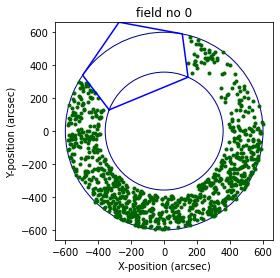

In [17]:
ax = plt.axes()
ax.set_aspect('equal')
plt.plot(xposarcsec,yposarcsec,'.',color='darkgreen')

#obscuration poly
if config == 'fp':
    plt.plot(np.array([-334, -495, -274, 110, 145, -334]),
         np.array([129, 339, 661, 590, 327, 129]), '-b')
elif config == 'gmacs':
    plt.plot(np.array([-10.11/2, 10.11/2, 10.11/2, -10.11/2, -10.11/2])*60,
         np.array([9.11/2, 9.11/2, -9.11/2, -9.11/2, 9.11/2])*60, '-b')

#inner circle
if config == 'fp':
    minradarcsec = 357.9
    obscuration = plt.Circle([0,0],radius=minradarcsec,color='darkblue',fill=False)
    ax.add_artist(obscuration)

#outer circle
if config == 'fp':
    maxradarcsec = 600
elif config == 'gmacs':
    maxradarcsec = 420
outercircle = plt.Circle([0,0],radius=maxradarcsec,color='darkblue',fill=False)
ax.add_artist(outercircle)

#plt.plot([0],[0],'*',color='black')

plt.xlim([-maxradarcsec*1.1, maxradarcsec*1.1])
plt.ylim([-maxradarcsec*1.1, maxradarcsec*1.1])
plt.xlabel('X-position (arcsec)')
plt.ylabel('Y-position (arcsec)')
plt.title(f'field no {fieldno}')

In [47]:
outputfilename.replace('csv','png')

'/home/ubuntu/PYTHON/AGWS/Fields/gmacs_asterism_0000.png'

In [48]:
outputfilename

'/home/ubuntu/PYTHON/AGWS/Fields/gmacs_asterism_0000.csv'

In [18]:
gspos = np.transpose(np.array([xposarcsec,yposarcsec]))

# determine which probes reach which stars
probesreachstars = agwsreachstars(validator,gspos)

In [19]:
probesreachstars.shape

(4, 909)

In [20]:
np.sum(probesreachstars)

1407

In [21]:
# select the segment tip-tilt star and the associated probe
# zenith angle in radians (used to find the anisoplanatic error)

# find the star with the lowest segment tip-tilt error
# inputs: distance from center in arcminutes, mV (currently); need to fix
radialdistArcmin = np.hypot(xposarcsec,yposarcsec)/60.

# calculate the seeing 
gs_wavelength = Quantity(*cfg['SH']['guide star']['wavelength']).to('m').value
r0_wavelength = Quantity(*cfg['Atmosphere']['wavelength']).to('m').value
r0_val = Quantity(*cfg['Atmosphere']['r0']).to('m').value
r0_val *= atp.r0_scaling(r0_wavelength,gs_wavelength,telzen)
seeingRad = gs_wavelength/r0_val
seeingArcsec = seeingRad*ceo.constants.RAD2ARCSEC
print("seeing (arcsec) : %5.3f" %seeingArcsec)

seeing (arcsec) : 0.757


### we next determine the best TT7 star, i.e., which star will be measured with the TT7 probe

we do this by predicting the TT7 error for each star

This error has two parts, the noise_rms and aniso_rms.

In [17]:
# TT7 tip-tilt error per subaperture (24x24 subapertures)
# use the interaction matrix to obtain the error in segment tip-tilt
# 

# calculate at what magnitude we saturate and define as minimum magnitude

# calculate the anisoplanatic error by setting magnitude to 0
tt7_aniso_rms = [atp.tt7_tt_error(zz,0.,telzen,**cfg) for zz,magnitude in zip(radialdistArcmin,vismag)]
# calculate the approximate TT7 error
# saturation is attained for magnitude 10 stars
# values calculated using tt7noise.i for 0.8" seeing
magvec = np.array([0,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,20])
# this is the error in the segment tip-tilt estimate using a 24x24 SH WFS
tterr_for_800mas = np.array([0.00204073,0.00204073,0.00248421,0.00313843,0.00404597,0.0052902,0.00649479,
                             0.00812451,0.0108732,0.0140705,0.018404,0.0248977,0.0369819,0.0556996,0.0910204,
                             0.13293,0.179323,0.205629,0.205629])*1000.
tterr_mas = tterr_for_800mas*seeingArcsec/0.8

Text(0, 0.5, 'Tip-tilt error (nm)')

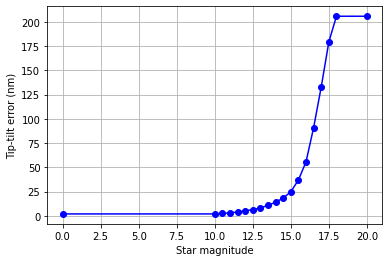

In [28]:
plt.plot(magvec, tterr_for_800mas, '-bo')
plt.grid()
plt.xlabel('Star magnitude')
plt.ylabel('Tip-tilt error (nm)')

In [18]:
interp_function = scipy.interpolate.interp1d(magvec,tterr_mas,bounds_error=False)
tt7_noise_rms = interp_function(np.clip(vismag,np.min(magvec),np.max(magvec)))
tt7_res_rms = tt7_noise_rms + tt7_aniso_rms

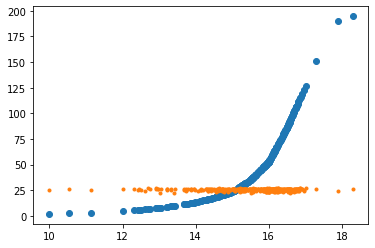

In [22]:
plt.plot(vismag, tt7_noise_rms,'o', vismag, tt7_aniso_rms, '.')

#### for now, we will use the best TT7 star, but later we could also try the other stars if we do not succeed in finding a suitable active optics asterism

In [30]:
# sort from lowest to highest error
tt7_gs_indices = np.argsort(tt7_res_rms)
tt7_gs_idx = tt7_gs_indices[0] #index of gs used for tt7

In [31]:
tt7probes = np.where(probesreachstars[:,tt7_gs_idx])[0] #which probes can reach the selected tt7 gs
stt7 = np.array([tt7_gs_idx])[0] #index of gs used for tt7

probes_with_stars = probesreachstars.any(axis=1) #for example: [true, true, true, true]
n_probes_with_stars = np.sum(probes_with_stars) # number of probes that can reach any star, ideally, =4

results = {'minangle':[],'minradius':[],'maxmag':[],'tt7':[],'aco':[],'tt7probe':[],'acoprobes':[]} 

In [32]:
probesreachstars[:,tt7_gs_idx]

array([False, False, False,  True])

In [33]:
probes_with_stars

array([ True,  True,  True,  True])

In [34]:
if n_probes_with_stars == 4:  
    for tt7probe in tt7probes:    
        aco_idx = np.arange(4)
        aco_idx = np.delete(aco_idx,tt7probe)

        s2 = np.where(probesreachstars[aco_idx[2],:])[0]
        if s2.tolist() == []:
            np.delete(aco_idx,aco_idx[2])

        s1 = np.where(probesreachstars[aco_idx[1],:])[0]
        if s1.tolist() == []:
            np.delete(aco_idx,aco_idx[1])

        s0 = np.where(probesreachstars[aco_idx[0],:])[0]
        if s0.tolist() == []:
            np.delete(aco_idx,aco_idx[0])

        # sort according to the visible magnitude
        s0 = s0[np.argsort(vismag[s0])]
        s1 = s1[np.argsort(vismag[s1])]
        s2 = s2[np.argsort(vismag[s2])]

        m0 = np.clip(len(s0),0,maxstarsperprobe)
        m1 = np.clip(len(s1),0,maxstarsperprobe)
        m2 = np.clip(len(s2),0,maxstarsperprobe)

        testpos = np.zeros((4,2))
        testpos[tt7probe,:] = gspos[stt7]

        for k0 in range(m0):
            testpos[aco_idx[0],:] = gspos[s0[k0],:]
            for k1 in range(m1):
                testpos[aco_idx[1],:] = gspos[s1[k1],:]
                for k2 in range(m2):
                    testpos[aco_idx[2],:] = gspos[s2[k2],:]

                    (success,loc,idx) = agwscheck(validator,testpos)
                    if success:
                        # evaluate the maximum magnitude
                        maxmag = np.max(vismag[[s0[k0],s1[k1],s2[k2]]])

                        # evaluate the angle that each set of stars makes with respect to the center
                        az0 = np.arctan2(gspos[s0[k0],0],gspos[s0[k0],1])
                        az1 = np.arctan2(gspos[s1[k1],0],gspos[s1[k1],1])
                        az2 = np.arctan2(gspos[s2[k2],0],gspos[s2[k2],1])

                        radius0 = np.hypot(gspos[s0[k0],0],gspos[s0[k0],1])
                        radius1 = np.hypot(gspos[s1[k1],0],gspos[s1[k1],1])
                        radius2 = np.hypot(gspos[s2[k2],0],gspos[s2[k2],1])

                        az = np.sort(np.array([az0,az1,az2]))
                        minangle = np.min([az[1]-az[0],az[2]-az[1],az[0]+2*np.pi-az[2]])

                        minradius = np.min([radius0,radius1,radius2])

                        results['minradius'].append(minradius)
                        results['minangle'].append(minangle*180./np.pi)
                        results['maxmag'].append(maxmag)
                        results['tt7'].append(stt7)
                        results['tt7probe'].append(tt7probe)
                        results['acoprobes'].append(aco_idx)
                        results['aco'].append(np.array([s0[k0],s1[k1],s2[k2]]))
    nAsterism = len(results['maxmag'])
else:
    nAsterism = 0

In [35]:
nAsterism

448

In [38]:
df = pd.DataFrame(results)
df.columns = ['minangle (deg)', 'minradius (arcsec)', 'maxmag (=faintest)', 
              'tt7 index', 'aco indices', 'tt7probe', 'acoprobes']

In [39]:
df

,minangle (deg),minradius (arcsec),maxmag (=faintest),tt7 index,aco indices,tt7probe,acoprobes
0,81.424803,370.412290,12.303300,147,"[200, 162, 308]",3,"[0, 1, 2]"
1,81.424803,370.412290,12.303300,147,"[200, 162, 321]",3,"[0, 1, 2]"
2,81.424803,370.412290,12.910417,147,"[200, 162, 233]",3,"[0, 1, 2]"
3,28.452210,370.412290,12.960970,147,"[200, 162, 273]",3,"[0, 1, 2]"
4,29.161730,370.412290,13.060136,147,"[200, 162, 259]",3,"[0, 1, 2]"
5,81.424803,370.412290,13.211569,147,"[200, 162, 349]",3,"[0, 1, 2]"
6,33.900710,355.155042,13.212706,147,"[200, 111, 308]",3,"[0, 1, 2]"
7,33.900710,355.155042,13.212706,147,"[200, 111, 162]",3,"[0, 1, 2]"
8,33.900710,355.155042,13.212706,147,"[200, 111, 321]",3,"[0, 1, 2]"
9,33.900710,355.155042,13.212706,147,"[200, 111, 233]",3,"[0, 1, 2]"


In [40]:
df.to_csv(outputfilename)

In [41]:
df1 = pd.read_csv(outputfilename)

In [43]:
len(df1)

448

In [59]:
sum(df1['tt7probe']>2)

448

In [16]:
outputfilename.upper()

'/HOME/UBUNTU/PYTHON/AGWS/FIELDS/GMACS_ASTERISM_0013.CSV'

### for GLAO

In [61]:
results = {'minangle (deg)':[],'minradius (arcsec)':[],'maxmag (=faintest)':[],
           'gs indices':[], 'star mag':[], 'xpos arcsec':[], 'ypos arcsec':[]}

s0 = np.where(probesreachstars[0,:])[0]
s1 = np.where(probesreachstars[1,:])[0]
s2 = np.where(probesreachstars[2,:])[0]
s3 = np.where(probesreachstars[3,:])[0]

# sort by magnitude and clip at maximum number
s0 = s0[np.argsort(vismag[s0])[0:maxstarsperprobe]]
s1 = s1[np.argsort(vismag[s1])[0:maxstarsperprobe]]
s2 = s2[np.argsort(vismag[s2])[0:maxstarsperprobe]]
s3 = s3[np.argsort(vismag[s3])[0:maxstarsperprobe]]

# see which combinations are allowable
validasterisms = []
for k0 in s0:
    for k1 in s1:
        for k2 in s2:
            for k3 in s3:
                testpos = gspos[[k0,k1,k2,k3]]
                (success,loc,idx) = agwscheck(validator,testpos)
                if success and np.all(idx == np.array([0,1,2,3])):
                    validasterisms.append([k0,k1,k2,k3])

                    # evaluate the maximum magnitude
                    maxmag = np.max(vismag[[k0, k1, k2, k3 ]])

                    # evaluate the angle that each set of stars makes with respect to the center
                    az0 = np.arctan2(gspos[k0,0],gspos[k0,1])
                    az1 = np.arctan2(gspos[k1,0],gspos[k1,1])
                    az2 = np.arctan2(gspos[k2,0],gspos[k2,1])
                    az3 = np.arctan2(gspos[k3,0],gspos[k3,1])

                    az = np.sort(np.array([az0,az1,az2,az3]))
                    minangle = np.min([az[1]-az[0],az[2]-az[1], az[3]-az[2],az[0]+2*np.pi-az[3]])

                    radius0 = np.hypot(gspos[k0,0],gspos[k0,1])
                    radius1 = np.hypot(gspos[k1,0],gspos[k1,1])
                    radius2 = np.hypot(gspos[k2,0],gspos[k2,1])
                    radius3 = np.hypot(gspos[k3,0],gspos[k3,1])

                    minradius = np.min([radius0,radius1,radius2, radius3])

                    results['minradius (arcsec)'].append(minradius)
                    results['minangle (deg)'].append(minangle*180./np.pi)
                    results['maxmag (=faintest)'].append(maxmag)
                    results['gs indices'].append(np.array([k0,k1,k2,k3]))
                    results['star mag'].append(np.round(vismag[[k0, k1, k2, k3 ]],6))
                    results['xpos arcsec'].append(np.round(xposarcsec[[k0, k1, k2, k3 ]],2))
                    results['ypos arcsec'].append(np.round(yposarcsec[[k0, k1, k2, k3 ]],2))

In [47]:
vismag[[k0, k1, k2, k3 ]]

array([13.41429269, 12.60056071, 12.48214878, 12.64587081])

In [57]:
np.round(xposarcsec[[k0, k1, k2, k3 ]],2)

array([ 273.69, -420.46, -251.31,  421.63])

In [50]:
np.array([k0,k1,k2,k3])

array([505, 331, 679, 134])

In [62]:
df = pd.DataFrame(results)

In [63]:
df

,minangle (deg),minradius (arcsec),maxmag (=faintest),gs indices,star mag,xpos arcsec,ypos arcsec
0,20.642226,407.667057,10.965904,"[600, 393, 71, 798]","[10.658705, 9.7775, 10.529598, 10.965904]","[-460.05, -495.27, 346.46, 566.63]","[287.18, -6.08, -214.85, -111.81]"
1,32.678143,407.667057,11.507955,"[600, 393, 71, 532]","[10.658705, 9.7775, 10.529598, 11.507955]","[-460.05, -495.27, 346.46, 484.36]","[287.18, -6.08, -214.85, 209.9]"
2,32.678143,495.308997,10.709084,"[600, 393, 568, 621]","[10.658705, 9.7775, 10.709084, 9.186929]","[-460.05, -495.27, -39.54, 537.98]","[287.18, -6.08, -532.95, -91.43]"
3,32.678143,407.667057,10.709084,"[600, 393, 568, 71]","[10.658705, 9.7775, 10.709084, 10.529598]","[-460.05, -495.27, -39.54, 346.46]","[287.18, -6.08, -532.95, -214.85]"
4,32.678143,495.308997,10.965904,"[600, 393, 568, 798]","[10.658705, 9.7775, 10.709084, 10.965904]","[-460.05, -495.27, -39.54, 566.63]","[287.18, -6.08, -532.95, -111.81]"
5,32.678143,495.308997,11.507955,"[600, 393, 568, 532]","[10.658705, 9.7775, 10.709084, 11.507955]","[-460.05, -495.27, -39.54, 484.36]","[287.18, -6.08, -532.95, 209.9]"
6,32.678143,409.648339,12.012608,"[600, 393, 568, 83]","[10.658705, 9.7775, 10.709084, 12.012608]","[-460.05, -495.27, -39.54, 299.3]","[287.18, -6.08, -532.95, -279.7]"
7,25.105149,445.237390,12.124788,"[600, 393, 568, 215]","[10.658705, 9.7775, 10.709084, 12.124788]","[-460.05, -495.27, -39.54, 158.56]","[287.18, -6.08, -532.95, -416.05]"
8,32.678143,495.308997,12.266086,"[600, 393, 568, 897]","[10.658705, 9.7775, 10.709084, 12.266086]","[-460.05, -495.27, -39.54, 552.52]","[287.18, -6.08, -532.95, -228.47]"
9,32.678143,425.724190,12.645871,"[600, 393, 568, 134]","[10.658705, 9.7775, 10.709084, 12.645871]","[-460.05, -495.27, -39.54, 421.63]","[287.18, -6.08, -532.95, -58.93]"


In [69]:
df['selected']=1

In [72]:
sortedmags = np.sort(np.array(results['star mag']),axis=1)

In [85]:
i = 3
while sum(df['selected'])>1:
    idx3 = np.where(sortedmags[:,i] != np.min(sortedmags[:,i]))[0]
    df['selected'][idx3]=0
    i-=1

In [87]:
idx = df['selected'] == 1
df['star mag'][idx]

2    [10.658705, 9.7775, 10.709084, 9.186929]
Name: star mag, dtype: object

In [86]:
df

,minangle (deg),minradius (arcsec),maxmag (=faintest),gs indices,star mag,xpos arcsec,ypos arcsec,selected
0,20.642226,407.667057,10.965904,"[600, 393, 71, 798]","[10.658705, 9.7775, 10.529598, 10.965904]","[-460.05, -495.27, 346.46, 566.63]","[287.18, -6.08, -214.85, -111.81]",0
1,32.678143,407.667057,11.507955,"[600, 393, 71, 532]","[10.658705, 9.7775, 10.529598, 11.507955]","[-460.05, -495.27, 346.46, 484.36]","[287.18, -6.08, -214.85, 209.9]",0
2,32.678143,495.308997,10.709084,"[600, 393, 568, 621]","[10.658705, 9.7775, 10.709084, 9.186929]","[-460.05, -495.27, -39.54, 537.98]","[287.18, -6.08, -532.95, -91.43]",1
3,32.678143,407.667057,10.709084,"[600, 393, 568, 71]","[10.658705, 9.7775, 10.709084, 10.529598]","[-460.05, -495.27, -39.54, 346.46]","[287.18, -6.08, -532.95, -214.85]",0
4,32.678143,495.308997,10.965904,"[600, 393, 568, 798]","[10.658705, 9.7775, 10.709084, 10.965904]","[-460.05, -495.27, -39.54, 566.63]","[287.18, -6.08, -532.95, -111.81]",0
5,32.678143,495.308997,11.507955,"[600, 393, 568, 532]","[10.658705, 9.7775, 10.709084, 11.507955]","[-460.05, -495.27, -39.54, 484.36]","[287.18, -6.08, -532.95, 209.9]",0
6,32.678143,409.648339,12.012608,"[600, 393, 568, 83]","[10.658705, 9.7775, 10.709084, 12.012608]","[-460.05, -495.27, -39.54, 299.3]","[287.18, -6.08, -532.95, -279.7]",0
7,25.105149,445.237390,12.124788,"[600, 393, 568, 215]","[10.658705, 9.7775, 10.709084, 12.124788]","[-460.05, -495.27, -39.54, 158.56]","[287.18, -6.08, -532.95, -416.05]",0
8,32.678143,495.308997,12.266086,"[600, 393, 568, 897]","[10.658705, 9.7775, 10.709084, 12.266086]","[-460.05, -495.27, -39.54, 552.52]","[287.18, -6.08, -532.95, -228.47]",0
9,32.678143,425.724190,12.645871,"[600, 393, 568, 134]","[10.658705, 9.7775, 10.709084, 12.645871]","[-460.05, -495.27, -39.54, 421.63]","[287.18, -6.08, -532.95, -58.93]",0


In [105]:
stats = {'field No.':[],'N asterisms':[],'brightest faint star':[],
                   'minradius (arcsec)':[], 'star mag':[], 'xpos arcsec':[], 'ypos arcsec':[]}
for fieldno in range(0, 15):
    outputfilename = f'output/fp_GLAO_asterism_{fieldno:04d}.csv'
    df = pd.read_csv(outputfilename)

    stats['field No.'].append(fieldno)
    stats['N asterisms'].append(len(df))
    if len(df)>0:
        idx = df['selected'] == 1
        #we may have >1 asterisms made of same set of stars
        stats['brightest faint star'].append(round(min(df['maxmag (=faintest)']),2))
        stats['minradius (arcsec)'].append(round(min(df['minradius (arcsec)']),2))
        stats['star mag'].append(np.array(df['star mag'][idx]))
        stats['xpos arcsec'].append(np.array(df['xpos arcsec'][idx]))
        stats['ypos arcsec'].append(np.array(df['ypos arcsec'][idx]))

In [107]:
stats

{'field No.': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'N asterisms': [1660,
  1440,
  1598,
  1459,
  1654,
  2276,
  1404,
  910,
  960,
  1221,
  1576,
  1910,
  1447,
  1114,
  1376],
 'brightest faint star': [10.71,
  11.99,
  10.41,
  9.18,
  12.89,
  13.15,
  11.66,
  14.1,
  11.52,
  12.96,
  12.44,
  12.17,
  13.11,
  15.1,
  11.19],
 'minradius (arcsec)': [406.0,
  423.94,
  396.26,
  393.76,
  391.75,
  391.73,
  394.09,
  401.63,
  392.55,
  403.89,
  392.88,
  396.56,
  392.24,
  404.64,
  402.01],
 'star mag': [array(['[10.658705  9.7775   10.709084  9.186929]'], dtype=object),
  array(['[11.991893  6.953286 11.270722 11.178938]'], dtype=object),
  array(['[10.407181 10.295856 10.311688 10.219561]'], dtype=object),
  array(['[8.377263 8.381766 5.098359 9.183886]'], dtype=object),
  array(['[12.892912 11.188899 11.334885 11.413458]'], dtype=object),
  array(['[ 8.847698 13.152576 12.563606 12.37437 ]'], dtype=object),
  array(['[ 9.48278  11.378871 10.310062 11

In [119]:
idx = df['selected'] == 1

In [118]:
df['selected'][np.where(np.array(idx))[0][1:]]=0

In [120]:
df['star mag'][idx]

0    [10.551518 11.045315  7.95634  11.191193]
Name: star mag, dtype: object

In [33]:
sortedmags = np.sort(mags,axis=1)
idx3 = np.where(sortedmags[:,3] == np.min(sortedmags[:,3]))[0]
if len(idx3) == 1:
    idx = idx3[0]
else:
    # asterisms with fourth brightest star of equal magnitudes
    idx2 = idx3[np.where(sortedmags[idx3,2] == np.min(sortedmags[idx3,2]))[0]]
    if len(idx2) == 1:
        idx = idx2[0]
    else:
        idx1 = idx2[np.where(sortedmags[idx2,1] == np.min(sortedmags[idx2,1]))[0]]
        if len(idx1) == 1:
            idx = idx1[0]
        else:
            idx0 = idx1[np.where(sortedmags[idx1,0] == np.min(sortedmags[idx1,0]))[0]]
            idx = idx0[0]

In [34]:
idx

2

In [35]:
vidx = validasterisms[idx]
xpos = xposarcsec[vidx]
ypos = yposarcsec[vidx]
mag = vismag[vidx]

In [36]:
mag

array([10.65870517,  9.77749988, 10.70908444,  9.18692908])

In [39]:
stats = {'field No.':[],'N asterisms':[],'star mag':[], 'xpos arcsec':[], 'ypos arcsec':[]}